## ch17 Model Interpretation
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.8</div>
<div style="text-align: right"> Last update: 2023.8.8</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

### 17.1 Logistic Regression Interpretation

In [9]:
from sklearn import linear_model, preprocessing

In [10]:
std = preprocessing.StandardScaler()
lr = linear_model.LogisticRegression(penalty=None)
lr.fit(std.fit_transform(X_train), y_train)
lr.score(std.transform(X_test), y_test)

0.7337016574585635

In [11]:
lr.coef_

array([[-1.59051061e-01, -4.02827023e-01,  6.06203075e-01,
        -1.45922113e-01, -8.12626418e-02, -6.05916337e-01,
         3.18051156e-02,  3.15043497e-02, -3.13556662e-02,
        -4.75174987e-04, -8.04790381e-03, -5.22558905e-02,
        -5.08749356e-03,  1.01987638e-01,  3.50075802e-01,
        -1.79333801e-01,  2.44937585e-02, -3.38714464e-01]])

<Axes: >

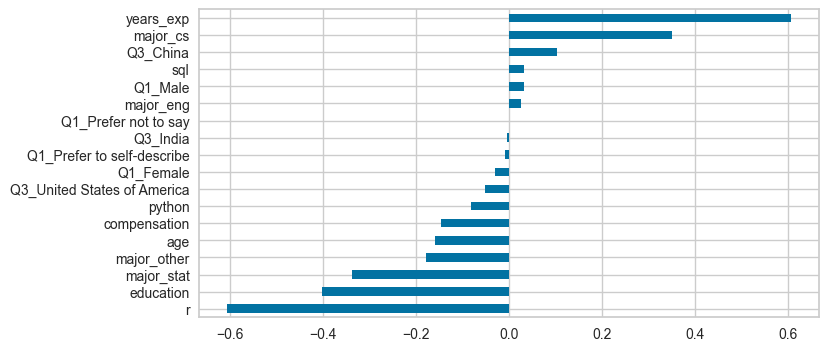

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(lr.coef_[0], index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)

### 17.2 Decision Tree Interpretation

In [13]:
tree7 = tree.DecisionTreeClassifier(max_depth=7)
tree7.fit(X_train, y_train)
tree7.score(X_test, y_test)

0.7359116022099448

<Axes: >

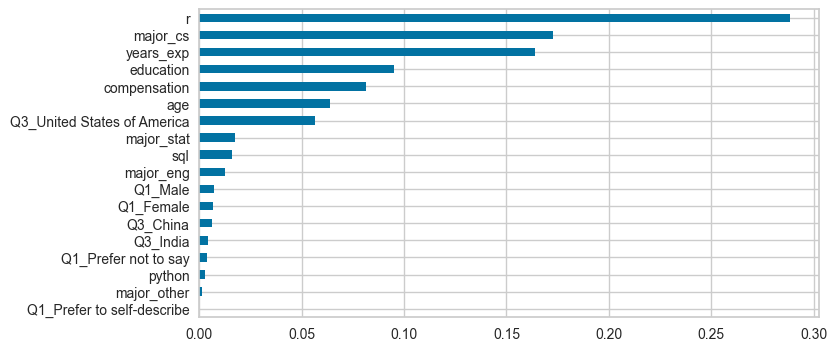

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(tree7.feature_importances_, index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)

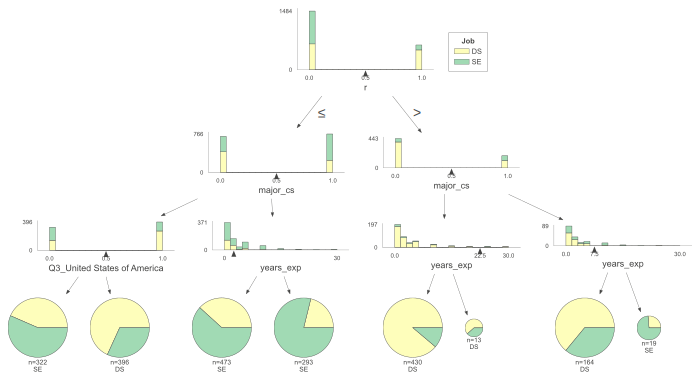

In [15]:
import dtreeviz
dt3 = tree.DecisionTreeClassifier(max_depth=3)
dt3.fit(X_train, y_train)
viz = dtreeviz.model(dt3, X_train=X_train, y_train=y_train,
feature_names=list(X_train.columns), target_name='Job',
class_names=['DS', 'SE'])
viz.view()

### 17.3 XGBoost Feature Importance

<Axes: >

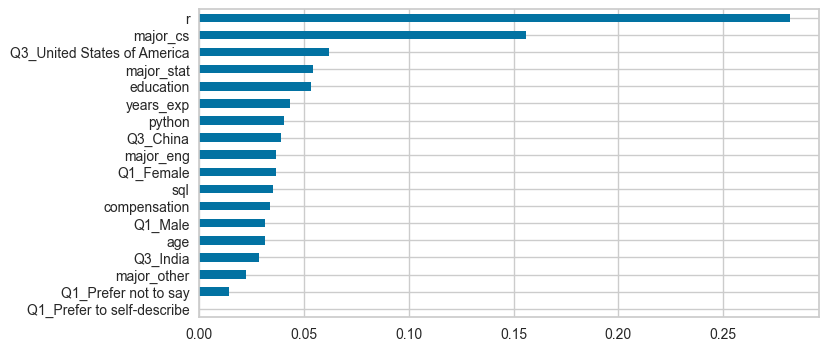

In [16]:
xgb_def = xgb.XGBClassifier()
xgb_def.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(8, 4))
(pd.Series(xgb_def.feature_importances_, index=X_train.columns)
.sort_values()
.plot.barh(ax=ax)
)

xgboost의 plot_importance로도 차트를 그릴 수 있다.   
여기에는 여러 종류의 feature importance가 내장되어 있다.  
- The 'gain' feature importance is calculated as the total gain in the model’s performance
that results from using a feature.
- The 'weight' feature importance is calculated as the number of times a feature is used in
the model.
- The 'cover' feature importance is calculated as the number of samples that are affected
by a feature.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

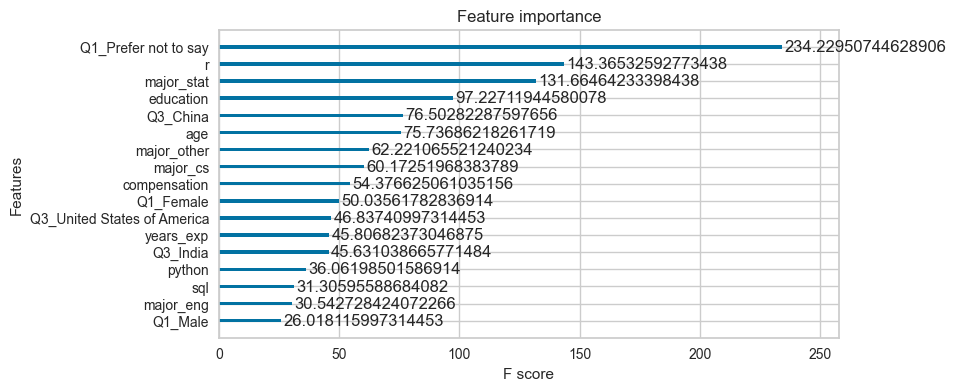

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_importance(xgb_def, importance_type='cover', ax=ax)